<a href="https://colab.research.google.com/github/AHamamd150/ML_Course_BUE/blob/main/BUE_2024/codes/VisionTransformer_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook implements the vision transformer model with an end to end training on fashion mnist datset

In [ ]:
#please install the keras_nlp to use the transformer encoder
%pip install keras_nlp

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers
import sys
from keras_nlp.layers import TransformerEncoder

In [2]:
num_classes = 10
input_shape =(28,28,1)
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0
x_train = x_train[...,tf.newaxis].astype('float32')
x_test = x_test[...,tf.newaxis].astype('float32')
loss_func = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
print(f'''x_train: {x_train.shape}
x_test: {x_test.shape}
y_train: {y_train.shape}
y_test: {y_test.shape}''')

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train: (60000, 28, 28, 1) 
x_test: (10000, 28, 28, 1)
y_train: (60000,)
y_test: (10000,)


In [3]:
batch_size=256
kernel_size = 4
epoch = 20
image_size = 28
num_heads = 4
num_transformers= 4
num_patches = (image_size // kernel_size) ** 2
projection_dim = 32
mlp_head_units = [256, 128]

In [4]:
class Patches_extraction(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1], ## We can scale the output patches
            padding="VALID", ## To not keep the same output dimensions as input one
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims]) # (patch size, num_constit, features)
        return patches

Image size: 28x28
Number of patches: 49


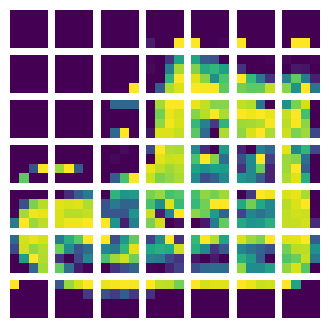

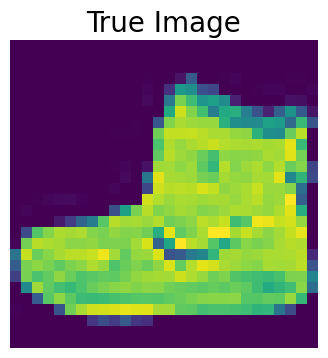

In [5]:
b1 = Patches_extraction(kernel_size)(x_train)
im_num = 0
print(f'Image size: {image_size}x{image_size}')
print(f'Number of patches: {len(b1[1])}')

n = int(np.sqrt(b1.shape[1]))
fig = plt.figure(figsize=(4, 4))
for i in range(len(b1[im_num])):
    y = fig.add_subplot(n,n,i+1)
    patch_im = tf.reshape(b1[im_num][i],(kernel_size,kernel_size,1))
    plt.imshow(patch_im)
    plt.axis("off")
im = x_train[im_num].reshape(28,28)
plt.figure(figsize=(4, 4))
plt.imshow(im)
plt.axis('off')
plt.title('True Image',fontsize=20);

In [6]:
### the final MLP layers
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Encode the patches with their positions
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [7]:
#Initiate the transformer encoder
transformer_encoder = TransformerEncoder(intermediate_dim=projection_dim, num_heads=num_heads,dropout=0.1)

In [8]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = Patches_extraction(kernel_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    # Create multiple layers of the Transformer block.
    for _ in range(num_transformers):
        encoded_patches = transformer_encoder(encoded_patches)
    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.2)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.2)
    logits = layers.Dense(num_classes)(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [9]:
model = create_vit_classifier()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patches_extraction_1      │ (None, None, 16)       │              0 │ input_layer[0][0]      │
│ (Patches_extraction)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_encoder             │ (None, 49, 32)         │          2,112 │ patches_extraction_1[… │
│ (PatchEncoder)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder       │ (None, 49, 32)         │          6,464 │ patch_encoder[0][0],   │
│ (TransformerEncoder)      │                        │                │ transformer_encoder[0… │
│                           │                        │                │ transformer_encoder[1… │
│                           │                        │                │ transformer_encoder[2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 49, 32)         │             64 │ transformer_encoder[3… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 1568)           │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 1568)           │              0 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        401,664 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         32,896 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 10)             │          1,290 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 444,490 (1.70 MB)

 Trainable params: 444,490 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

* Now we have created the ViT model, lets create the train and test loop

In [10]:
### Training loop function per training batch
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_func(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_accuracy.update_state(y, logits)
    return loss_value,train_accuracy.result()

In [11]:
### function to test the loss and accuracy per training batch
@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    test_accuracy.update_state(y, val_logits)
### Function to the test the model accuracy on the model test data
def test_acc(model,x, y):
    val_logits = model(x, training=False)
    test_accuracy.update_state(y, val_logits)
    return print(f'Test Accuracy:  {test_accuracy.result()*100 :.3f}%')

In [12]:
## Define the traning loop

def training_loop(model,x_train,y_train,epochs=20,batch_size=512):
    ## Lets create the batches first
    train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(x_train.shape[0]).batch(batch_size)
    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_acc_avg = tf.keras.metrics.Mean()
    for epoch in range(epochs):
    # Iterate over the batches of the dataset.
        loss,acc = [],[]
        for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
            loss_value,acc_value = train_step(x_batch_train, y_batch_train)
            loss.append(loss_value)
            acc.append(acc_value)
            epoch_loss_avg.update_state(loss)
            epoch_acc_avg.update_state(acc)
            if step % 1 == 0:
                sys.stdout.write('\r'+'step %s :  loss = %2.5f  accuracy = %2.5f'%((step + 1),float(loss_value),float(acc_value)))

        # Display metrics at the end of each epoch.
        tf.print('|   Epoch {:2d}:  Loss (Avg): {:2.5f}  Accuracy (Avg): {:2.5f}'.format(epoch+1,epoch_loss_avg.result(),epoch_acc_avg.result()))
        # Reset training metrics at the end of each epoch
        train_accuracy.reset_states()

In [ ]:
training_loop(model,x_train,y_train,epochs=epoch,batch_size=batch_size)

In [ ]:
test_acc(model,x_test,y_test)

Test Accuracy:  91.220%
